In [1]:
import torch
import torch.nn as nn
from typing import Optional
import matplotlib.pyplot as plt

In [2]:
class MyPlannerTransformer(nn.Module):
    def __init__(self, num_features=6, numOfEncoderLayers = 2, numOfDecoderLayers=2) -> None:
        super().__init__()
        self.transformer_model = nn.Transformer(
            d_model=num_features,
            nhead=1,
            num_encoder_layers=numOfEncoderLayers,
            num_decoder_layers=numOfDecoderLayers,
            dim_feedforward=2048,
            dropout=0.1,
        )
        # map tgt to have the same number of features as src
        self.tgt = nn.Linear(2, num_features)

    def forward(
        self,
        src: torch.tensor,
        tgt: torch.tensor,
        src_mask: Optional[torch.tensor]=None,
        tgt_mask: Optional[torch.tensor]=None,
        memory_mask: Optional[torch.tensor]=None,
        src_key_padding_mask: Optional[torch.tensor]=None,
        tgt_key_padding_mask: Optional[torch.tensor]=None,
        memory_key_padding_mask: Optional[torch.tensor]=None,
        max_len: Optional[int]=None,
        
    )->torch.tensor:
        tgt = self.tgt(tgt)
        out = self.transformer_model(src, tgt)
        return out[:,:2]
    
    def predict(self, src: torch.tensor, max_len: Optional[int] = None) -> torch.tensor:
        self.eval()
        max_len = 4 if max_len is None else max_len
        tgt_new = torch.zeros(max_len, 2)

        with torch.no_grad():
            for i in range(max_len):
                # Pass the previous predictions as the target sequence
                output = self.forward(src, tgt_new)

                # Get the last predicted token for each sequence in the batch
                predicted_token = output[-1, :]

                # Update the target sequence with the predicted tokens
                tgt_new[i, :] = predicted_token

        return tgt_new


         
    

In [3]:
#batch_size = 10
src = torch.load('../inputs/tensors/src.pt')
tgt = torch.load('../inputs/tensors/tgt.pt')

In [4]:
src.shape, tgt.shape

(torch.Size([13364, 5]), torch.Size([6490, 2]))

In [5]:
model = MyPlannerTransformer(num_features=5)
#model.forward(src, tgt).shape

c:\Users\ahmed\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [6]:
#model(src, tgt)

In [7]:
# import torch data loader
from torch.utils.data import DataLoader

src_train_loader = DataLoader(src, batch_size=100, shuffle=True)
tgt_train_loader = DataLoader(tgt, batch_size=100, shuffle=True)


In [8]:
def trainModel(model, src_loader, tgt_loader, epochs=10):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    LOSS = []
    VAL_LOSS = []
    for epoch in range(epochs):
        COST = 0
        VAL_COST = 0
        for src_batch, tgt_batch in zip(src_loader, tgt_loader):
            optimizer.zero_grad()
            prediction = model(src_batch, tgt_batch)
            loss = criterion(prediction, tgt_batch)
            loss.backward()
            COST += loss.item()
            optimizer.step()
        avg_loss = COST / len(src_loader)
        LOSS.append(avg_loss)
        with torch.no_grad():
            for src_batch, tgt_batch in zip(src_loader, tgt_loader):
                prediction = model.predict(src_batch, max_len=tgt_batch.shape[0])
                loss = criterion(prediction, tgt_batch)
            VAL_COST += loss.item()
        avg_val_loss = VAL_COST / len(src_loader)
        VAL_LOSS.append(avg_val_loss)
        
        print(f'Epoch: {epoch+1}, Training Loss: {avg_loss}, Validation Loss: {avg_val_loss}')


    return LOSS, VAL_LOSS

train_loss, val_loss = trainModel(model, src_train_loader, tgt_train_loader, epochs=10)

Epoch: 1, Training Loss: 24.88247236564978, Validation Loss: 0.5826184287000058
Epoch: 2, Training Loss: 22.609513069266704, Validation Loss: 0.4978219217328883
Epoch: 3, Training Loss: 22.05062359482495, Validation Loss: 0.6479127798507462
Epoch: 4, Training Loss: 21.533383611422867, Validation Loss: 0.5444218649793027
Epoch: 5, Training Loss: 21.03713086825698, Validation Loss: 0.5751309181327251
Epoch: 6, Training Loss: 20.56266097168424, Validation Loss: 0.46242249901614974
Epoch: 7, Training Loss: 20.100980673263322, Validation Loss: 0.5562319969063374
Epoch: 8, Training Loss: 19.66160717295177, Validation Loss: 0.522477904362465
Epoch: 9, Training Loss: 19.223881394115846, Validation Loss: 0.648714207891208
Epoch: 10, Training Loss: 18.798165990345513, Validation Loss: 0.5197447591753148


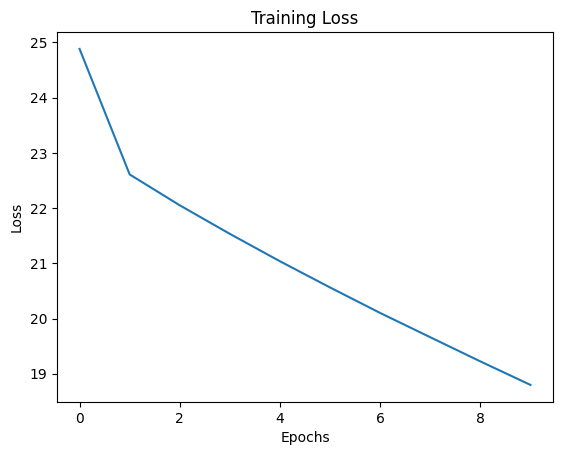

In [9]:
plt.plot(train_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

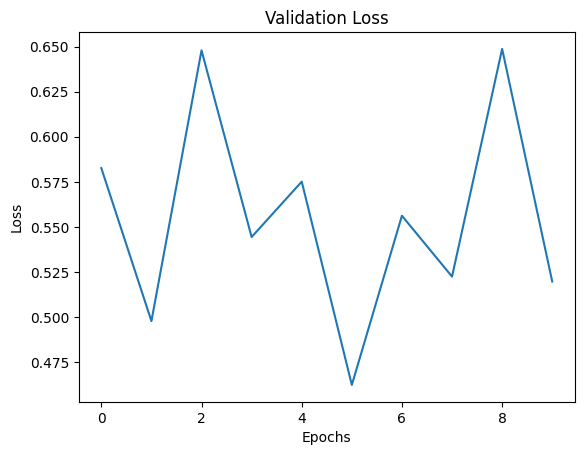

In [10]:
plt.plot(val_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.show()

In [11]:
# save model
#torch.save(model.state_dict(), 'model.pth')

In [12]:
# load model
#model.load_state_dict(torch.load('model.pth'))

In [13]:
yhat2 = model(src, tgt)

In [14]:
# predict
yhat = model.predict(src)

In [15]:
yhat2.shape, yhat.shape

(torch.Size([6490, 2]), torch.Size([4, 2]))

In [16]:
yhat[0], tgt[0], yhat2[0]

(tensor([2.0271, 0.7395]),
 tensor([1.5942, 0.7692]),
 tensor([2.5952, 1.3115], grad_fn=<SelectBackward0>))